In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from tf.app import use
A = use("ETCBC/dss", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
scroll,1001,1428.81,100
lex,10450,129.14,94
fragment,11182,127.91,100
line,52895,27.04,100
clause,125,12.85,0
cluster,101099,6.68,47
phrase,315,5.10,0
word,500995,2.81,99
sign,1430241,1.00,100


You can see which features have been loaded, and if you click on a feature name, you find its documentation.
If you hover over a name, you see where the feature is located on your system.

In [11]:
from tqdm import tqdm
import re
import pandas as pd
import matplotlib.pyplot as plt
chars_to_delete = re.compile("[\\\\\^><»≥≤/?Ø\\]\\[«|}{]")
def get_biblical_from_line(line):
    """
    Returns the biblical section of a line.
    """
    bib = F.biblical.v(line)
    if bib == None:
        return 'nonbib'
    elif bib == 1:
        return 'bib'
    elif bib == 2:
        return 'biblical_non_biblical'

def remove_chars(s):
    chars_to_delete = "#ε^><»≥≤/?Ø«|}{׳"
    for char in chars_to_delete:
        s = s.replace(char, "")
    return s


In [12]:

data = {}
books = {}
for line in tqdm(F.otype.s("line")[:]):
    book_and_chapter = A.sectionStrFromNode(line)
    book = A.sectionStrFromNode(line).split(" ")[0]
    text = book_and_chapter + "\t" + str(get_biblical_from_line(line)) + "\t"+ T.text(line)
    text = remove_chars(text).replace("\xa0", "").replace("׃",".")
    text = [text]
    if book not in data:
        data[book] = [text]
    else: 
        data[book].append(text)


100%|██████████| 52895/52895 [00:06<00:00, 8227.51it/s] 


In [14]:
from notebooks.utils import write_data, parse_data, generate_stats,plot_word_line_stats

# write_data(data,"all_data.txt")
df = parse_data(data)
book_stats, label_stats = generate_stats(df)


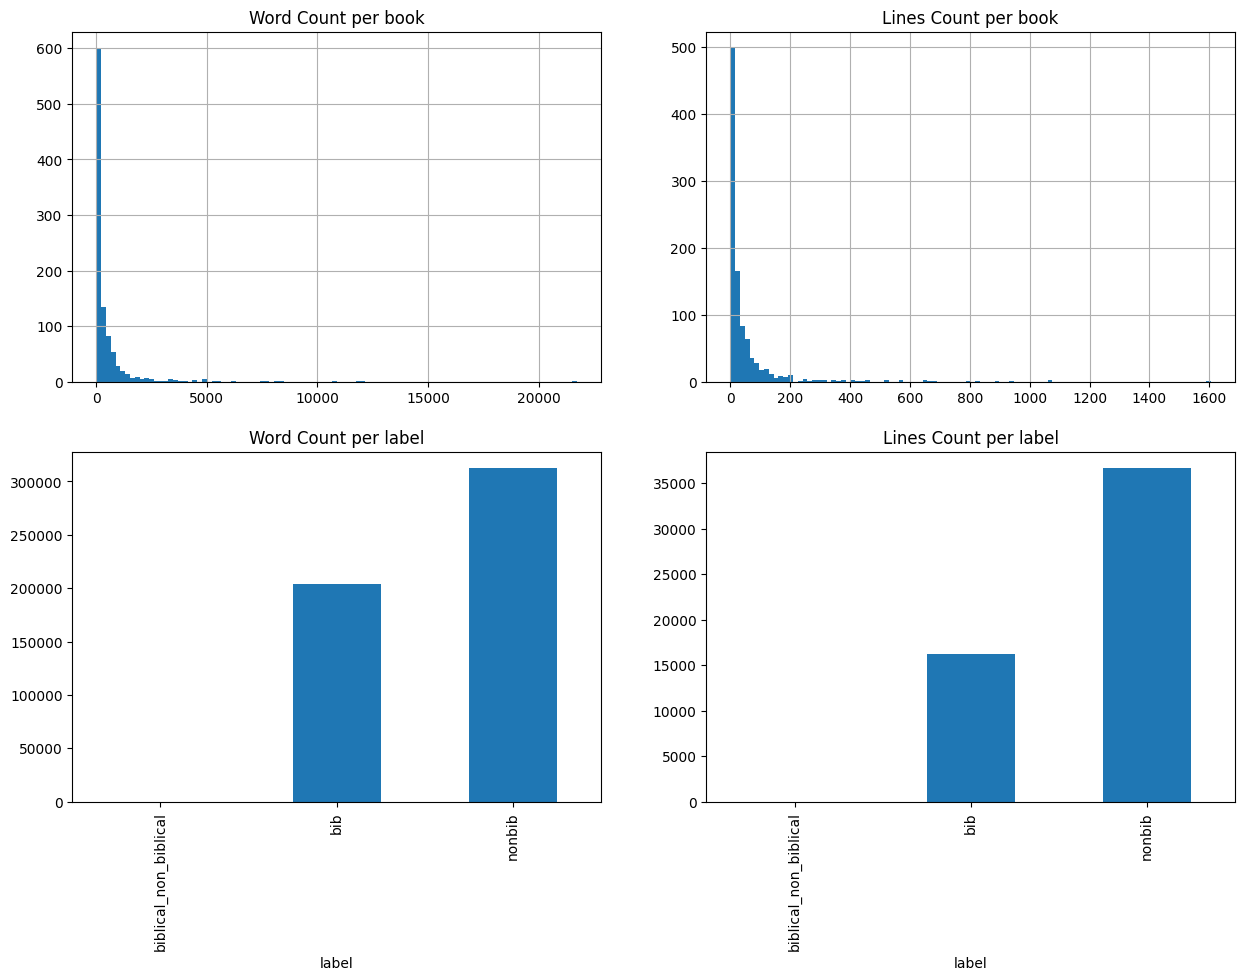

In [15]:
plot_word_line_stats(book_stats, label_stats)

In [17]:

from notebooks.utils import data_cleaning

df_filtered = data_cleaning(df, book_stats)

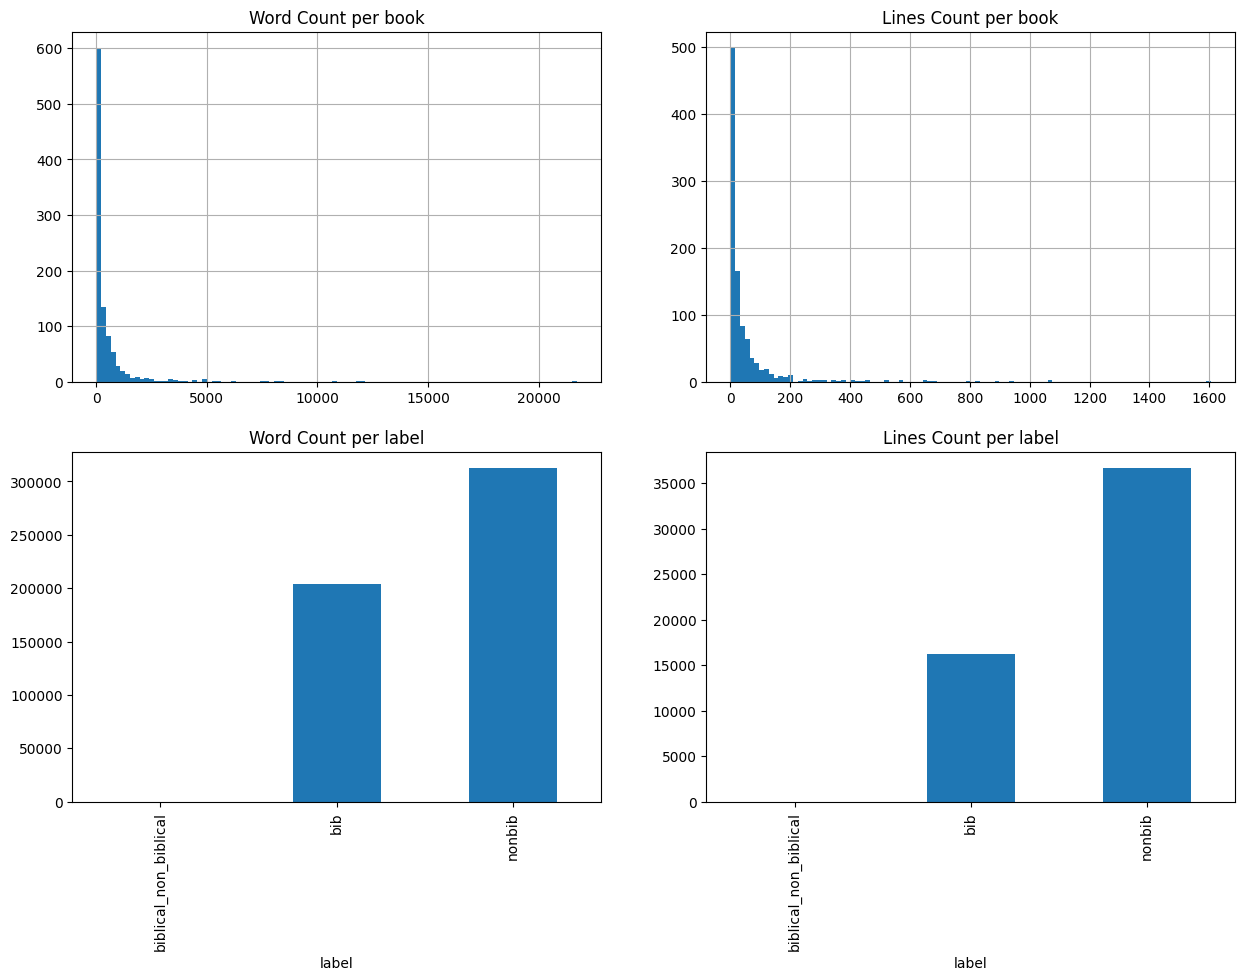

In [18]:
book_stats, label_stats = generate_stats(df)
plot_word_line_stats(book_stats, label_stats)

In [19]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_filtered, test_size=0.3, random_state=42, stratify=df_filtered["label"])
df_train["train_test"]="train"
df_test["train_test"]="test"
df_filtered = pd.concat([df_train, df_test])

In [20]:
df_filtered.groupby(["train_test","label"]).count()

book  pasuk   text  word_count  book_pasuk
train_test label                                              
test       bib      4673   4673   4673        4673        4673
           nonbib   8897   8897   8897        8897        8897
train      bib     10903  10903  10903       10903       10903
           nonbib  20760  20760  20760       20760       20760

In [322]:
# df_filtered[["book_pasuk", "train_test", "label"]].to_csv(
#         f"DSS_bibnobib_tf_labels.txt",
#         sep="\t",
#         index=False,
#         header=False,
#     )
# 
# df_filtered["text"].to_csv(
#         f"DSS_bibnobib_tf_text.txt", index=False, header=False
#     )

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
td = TfidfVectorizer(max_features = 4500)
X = df_filtered["text"]
y = df_filtered["label"]
X = td.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)
# Training the classifier & predicting on test data

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Classification metrics

classification_report_print = classification_report(y_test, y_pred)

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report_print)


 Accuracy:  0.8290346352247605

Classification Report

               precision    recall  f1-score   support

         bib       0.81      0.66      0.72      4651
      nonbib       0.84      0.92      0.88      8919

    accuracy                           0.83     13570
   macro avg       0.82      0.79      0.80     13570
weighted avg       0.83      0.83      0.82     13570


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from transformers import BertModel, BertTokenizer
import torch

# Assuming df_filtered is your DataFrame with 'text' and 'label' columns

# Define feature extraction methods
def tfidf_features(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=4500)
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()
    return X_train_tfidf, X_test_tfidf

def count_features(X_train, X_test):
    vectorizer = CountVectorizer(max_features=4500)
    X_train_count = vectorizer.fit_transform(X_train).toarray()
    X_test_count = vectorizer.transform(X_test).toarray()
    return X_train_count, X_test_count

# def bert_features(X_train, X_test):
#     tokenizer = BertTokenizer.from_pretrained('onlplab/alephbert-base')
#     model = BertModel.from_pretrained('onlplab/alephbert-base')
#     # Tokenization, Padding, and Truncation steps should be implemented here for both train and test sets
#     # Due to complexity, this is a placeholder to indicate where BERT processing would occur
#     # Return processed features for X_train and X_test
#     return X_train_bert, X_test_bert  # Placeholder

# Define classification models
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

# Results DataFrame
results_list = []

for feature_method in tqdm([tfidf_features, count_features, 
                       # bert_features
                       ]):
    # Split your dataset (do this inside the loop if you're including BERT, because BERT requires special handling)
    X_train, X_test, y_train, y_test = train_test_split(df_filtered['text'], df_filtered['label'], test_size=0.3, random_state=0)
    
    # Apply feature extraction
    X_train_fe, X_test_fe = feature_method(X_train, X_test)
    
    for model_name, model in tqdm(models.items()):
        # Train model
        model.fit(X_train_fe, y_train)
        # Predict
        y_pred = model.predict(X_test_fe)
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        # Append results
        result_dict = {
            'Feature Extraction': feature_method.__name__,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall
        }
        results_list.append(result_dict)
# Display or save results_df as required
results_df = pd.DataFrame(results_list)

print(results_df)

  0%|          | 0/2 [00:30<?, ?it/s]


KeyboardInterrupt: 

In [469]:
import numpy as np
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

conf_matrix

array([[3051, 1631],
       [ 662, 8168]])

In [422]:

incorrect_predictions = y_test[y_test != y_pred]
incorrect_predictions = df_filtered.loc[incorrect_predictions.index]
incorrect_predictions.groupby("book")["label"].value_counts().sort_values(ascending=False)


book    label 
1Qisaa  bib       161
4Q27    bib        74
11Q5    bib        73
4Q51    bib        55
4Q364   nonbib     53
                 ... 
4Q52    bib         1
4Q554   nonbib      1
1QSb    nonbib      1
4Q249z  nonbib      1
4Q427   nonbib      1
Name: count, Length: 103, dtype: int64